In [11]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [12]:
# statement, speaker_description, justification


def build_descriptive_text_vocab_ashley(input_text):
    vocab = set()
    vocab.add("<UNK>")
    for text in input_text:
        for word in text.split():
            word = remove_punctuation_ashley(word)
            if word:
                vocab.add(word)
    return {token: i for i, token in enumerate(vocab)}


def vectorize_descriptive_text_ashley(input_text, vocab):
    vectorized_text = np.zeros(len(vocab))
    for word in input_text.split():
        word = remove_punctuation_ashley(word)
        if word in vocab:
            vectorized_text[vocab[word]] += 1
        else:
            vectorized_text[vocab["<UNK>"]] += 1
    return vectorized_text


def remove_punctuation_ashley(word):
    punctuation = set([".", "(", ")", ",", ";", "?", "!", '"', ":", "'"])
    while word and word[0] in punctuation:
        word = word[1:]
    while word and word[-1] in punctuation:
        word = word[:-1]
    return word.lower()

In [13]:
# one hot encoding of subjects and context


# for the subject and context columns we only need to add each row into the vocab list and see if there are any repetitions
def build_descriptive_text_vocab_nruta(input_text):
    vocab = set()
    input_text = input_text.str.lower()
    for word in input_text:
        vocab.add(word)
    vocab.add("<UNK>")
    return {token: i for i, token in enumerate(vocab)}


def vectorize_descriptive_text_nruta(input_text, vocab):
    vectorized_text = np.zeros(len(vocab))
    for word in input_text:
        if word in vocab:
            vectorized_text[vocab[word]] += 1
        else:
            vectorized_text[vocab["<UNK>"]] += 1
    return vectorized_text

In [14]:
def build_descriptive_text_vocab_subject_stateInfo_nakiyah(input_text):
    vocab = set()
    vocab.add("<UNK>")
    input_text = input_text.str.lower()
    input_text = input_text.astype(str)

    # Build vocabulary
    for text in input_text:
        for word in text.split(";"):
            word = word.strip()  # Remove extra spaces
            if word:
                vocab.add(word)

    return {token: i for i, token in enumerate(vocab)}


def vectorize_descriptive_text_subject_nakiyah(input_text, vocab):
    # Ensure the input is a string
    if isinstance(input_text, list):
        input_text = ";".join(input_text)  # Join list into a string
    vectorized_text = np.zeros(len(vocab))
    for word in input_text.split(";"):
        if word in vocab:
            vectorized_text[vocab[word]] += 1
        else:
            vectorized_text[vocab["<UNK>"]] += 1
    return vectorized_text

### Converting csv to a PyTorch Dataset Object

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transform
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

In [17]:
def process_data(df, vocabs):
    """
    Processes a dataset file to encode categorical variables and convert data into PyTorch tensors.

    Args:
        file_path (str): Path to the CSV file

    Returns:
        tuple: A tuple containing:
        - features_tensor (torch.Tensor) : Tensor of features
        - labels_tensor (torch.Tensor) : Tensor of labels.
        - label_encoders (dict): Dictionary of LabelEncoders for categorical columns
    """
    print("processing data")
    # drop useless data
    dropped_columns = ["id", "date"]
    df = df.drop(dropped_columns, axis=1)
    
    for col in ["statement", "justification", "speaker_description"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_ashley(x, vocabs[col]))
        
    for col in ["subject", "state_info"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_subject_nakiyah(x, vocabs[col]))
        
    for col in ["speaker", "context"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_nruta(x, vocabs[col]))

    return df

def create_vocabs():
    df = pd.read_csv("data/train.csv")
    dropped_columns = ["id", "date"]
    df = df.drop(dropped_columns, axis=1)
    
    vocabs = {}
    for col in ["statement", "justification", "speaker_description"]:
        df[col] = df[col].fillna("None").astype(str)
        V = build_descriptive_text_vocab_ashley(df[col])
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_ashley(x, V))
        vocabs[col] = V
        
    for col in ["subject", "state_info"]:
        df[col] = df[col].fillna("None").astype(str)
        V = build_descriptive_text_vocab_subject_stateInfo_nakiyah(df[col])
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_subject_nakiyah(x, V))
        vocabs[col] = V
        
    for col in ["speaker", "context"]:
        df[col] = df[col].fillna("None").astype(str)
        V = build_descriptive_text_vocab_nruta(df[col])
        df[col] = df[col].apply(lambda x: vectorize_descriptive_text_nruta(x, V))
        vocabs[col] = V
    return vocabs

In [18]:
class SentimentDataset(Dataset):
    def __init__(self, path, vocabs, transform=None):
        self.sentiment = pd.read_csv(path)
        self.sentiment = process_data(self.sentiment, vocabs)
        self.transform = transform
        
        
    def __len__(self):
        return len(self.sentiment)
    
    def __getitem__(self, idx):
        data = self.sentiment.iloc[idx]
        label = data["label"]
        data = data.drop("label")
        
        max_length = 0
        for col in data.index:
            value = data[col]
            if isinstance(value, (np.ndarray, list)):
                max_length = max(max_length, len(value))
        
        feature_vectors = []
        for col in data.index:
            value = data[col]
            if isinstance(value, (np.ndarray, list)):
                feature_vectors.append(np.array(value))
            else:
                feature_vectors.append(np.array([value], dtype=np.float32))

        feature_vectors = np.concatenate(feature_vectors)

        if self.transform:
            feature_vectors = self.transform(feature_vectors)
            
        return torch.tensor(feature_vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
        

In [ ]:
t = transform.Compose([transform.ToTensor()])
vocabs = create_vocabs()
train_dataset = SentimentDataset(path="data/train.csv", vocabs=vocabs)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
iterator = iter(dataloader)
data, label = next(iterator)

print(data.shape, label.shape)

processing data
torch.Size([1, 85446]) torch.Size([1])


### Training Neural Network

In [19]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim=85446, num_classes=6):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vocabs = create_vocabs()
train_dataset = SentimentDataset(path="data/train.csv", vocabs=vocabs)
test_dataset = SentimentDataset(path="data/test.csv", vocabs=vocabs)
val_dataset = SentimentDataset(path="data/valid.csv", vocabs=vocabs)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

processing data
processing data
processing data


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.81s/its]


Epoch 1/10: Train Loss:  1.4710, Val Loss: 1.4098097615771823, Train Accuracy:  43.25, Val Accuracy:  46.19


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.78s/its]


Epoch 2/10: Train Loss:  1.1255, Val Loss: 1.2877767152256436, Train Accuracy:  59.26, Val Accuracy:  50.20


Validating: 100%|██████████| 18/18 [00:33<00:00,  1.85s/its]


Epoch 3/10: Train Loss:  0.8864, Val Loss: 1.248604456583659, Train Accuracy:  68.42, Val Accuracy:  51.33


Validating: 100%|██████████| 18/18 [00:31<00:00,  1.74s/its]


Epoch 4/10: Train Loss:  0.7074, Val Loss: 1.4969594942198858, Train Accuracy:  74.74, Val Accuracy:  48.80


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.79s/its]


Epoch 5/10: Train Loss:  0.5551, Val Loss: 1.634317033820682, Train Accuracy:  80.45, Val Accuracy:  45.76


Validating: 100%|██████████| 18/18 [00:33<00:00,  1.84s/its]


Epoch 6/10: Train Loss:  0.4731, Val Loss: 1.5569566289583843, Train Accuracy:  84.21, Val Accuracy:  47.89


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.89s/its]


Epoch 7/10: Train Loss:  0.3736, Val Loss: 1.7344608041975234, Train Accuracy:  87.87, Val Accuracy:  43.62


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.83s/its]


Epoch 8/10: Train Loss:  0.2927, Val Loss: 1.9069085915883381, Train Accuracy:  90.79, Val Accuracy:  44.36


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.83s/its]


Epoch 9/10: Train Loss:  0.2567, Val Loss: 2.1879683799213834, Train Accuracy:  92.33, Val Accuracy:  44.10


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.89s/its]


Epoch 10/10: Train Loss:  0.2187, Val Loss: 1.8885815276039972, Train Accuracy:  93.56, Val Accuracy:  50.94


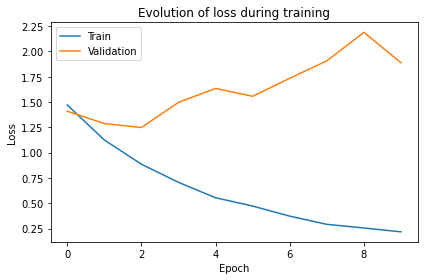

In [21]:
model = FakeNewsClassifier().to(device)
optimizer = Adam(model.parameters(), lr=.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 10
training_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    train_loss = 0
    val_loss = 0
    train_correct_predictions = 0
    train_total_samples = 0
    val_correct_predictions = 0
    val_total_samples = 0
    
    model.train()
    for features, labels in tqdm(train_loader, desc="Training", unit="its"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(features)
        t_loss = criterion(outputs, labels)
        t_loss.backward()
        optimizer.step()
        
        train_loss += t_loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        train_correct_predictions += (predicted == labels).sum().item()
        train_total_samples += labels.size(0)
        
    model.eval()
    for features, labels in tqdm(val_loader, desc="Validating", unit="its"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        with torch.no_grad():
            outputs = model(features)
            v_loss = criterion(outputs, labels)
        
        val_loss += v_loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_samples += labels.size(0)
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy = train_correct_predictions / train_total_samples * 100
    val_accuracy = val_correct_predictions / val_total_samples * 100
    print(f"Epoch {epoch}/{epochs}: Train Loss: {train_loss: .4f}, Val Loss: {val_loss}, Train Accuracy: {train_accuracy: .2f}, Val Accuracy: {val_accuracy: .2f}")
    
torch.save(model.state_dict(), "trained_model.pth")

plt.plot(np.arange(epochs), training_losses, label="Train")
plt.plot(np.arange(epochs), val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of loss during training")
plt.legend()
plt.tight_layout()
plt.show()

Testing: 100%|██████████| 18/18 [00:32<00:00,  1.79s/batch]


Accuracy: 0.4974
Precision: 0.5129
Recall: 0.4974
F1 Score: 0.4965

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.54      0.45       303
           1       0.51      0.60      0.55       660
           2       0.54      0.48      0.51       360
           3       0.59      0.40      0.48       371
           4       0.58      0.40      0.48       343
           5       0.42      0.46      0.44       259

    accuracy                           0.50      2296
   macro avg       0.51      0.48      0.48      2296
weighted avg       0.51      0.50      0.50      2296



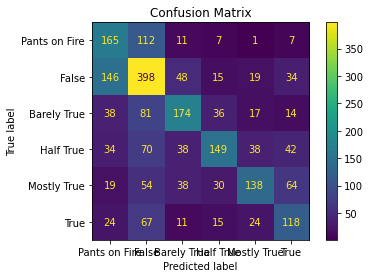

In [24]:
test_model = FakeNewsClassifier().to(device)
test_model.load_state_dict(torch.load("trained_model.pth"))
test_model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

corresponding_labels = ["Pants on Fire", "False", "Barely True", "Half True", "Mostly True", "True"]
ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions, display_labels=corresponding_labels)
plt.title("Confusion Matrix")
plt.savefig("results/confusion_matrix.png")
plt.show()